# Cebit Weather Hannover

Playing with visitor and weather data related to CeBIT in Hannover. The visitor data is based on the CeBIT entry on Wikipedia, the weather data is the historic data provided by Deutscher Wetterdienst (German Weather Service).

In our notebook the code snippets will be hidden once the cells are run. We will set up a connection to a dashDB service that holds the data, load two data frames, print out the table schemas and some data, then generate (plot) some graphs with the visitor count by year, weather data, and visitor and weather information combined.

In [96]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Setup connection and load data
First we set up the environment by importing packages, provide credentials for the database access, then we are connecting to the database, load the data frames and print out some basic schema information for both tables.

In [97]:
# import some required packages
import requests, StringIO, pandas as pd, json, re

In [98]:
# credentials for our dashDB service - remove before posting :)
credentials = {
    'port': '50000',
    'db': 'BLUDB',
    'username': 'dashXXXXXX',
    'jdbcurl': 'jdbc:db2://bluemixXXXX.bluforcloud.com:50000/BLUDB',
    'password': 'secret'
}

In [99]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [100]:
props = {}
props['user'] = credentials['username']
props['password'] = credentials['password']
# A table can be just the two-part table identifier or a subquery as it could be placed into the FROM clause.
# For our notebook we will use the subqueries to only load columns of interest and to aggregate data
# already in dashDB/DB2.
# This is how just a table could be loaded.
# table = credentials_2['username'] + "." + "CEBIT_VISITORS1"

# Two ugly queries...
table="(select v.year,v.visitors1,cast(sum(w.precip_hieght) as float) as rain,cast(sum(w.sunshine_duration) as float) as sun,cast(max(w.temp_max) as float) as tmax,cast(min(w.temp_min) as float) as tmin from "+credentials['username'] + "." + "CEBIT_VISITORS as v,"+credentials['username'] + ".WEATHER_HANNOVER w where v.year<2016 and w.mdate between v.begin and v.end group by v.year,v.visitors1)"
wtable="(select w.mdate,cast (w.sunshine_duration as float) as sun,cast(w.precip_hieght as float) as rain,cast(w.temp_max as float) as tmax,cast(w.temp_min as float) as tmin from "+credentials['username'] + "." + "CEBIT_VISITORS as v,"+credentials['username'] + ".WEATHER_HANNOVER w where w.mdate between v.begin and v.end and v.year<2016 order by w.mdate asc)"

# Load and cache the data frames
data_df = sqlContext.read.jdbc(credentials['jdbcurl'],table,properties=props)
wdf=sqlContext.read.jdbc(credentials['jdbcurl'],wtable,properties=props)
data_df.cache()
wdf.cache()
print "Schema information for CeBIT Visitors:"
data_df.schema

Schema information for CeBIT Visitors:


StructType(List(StructField(YEAR,IntegerType,true),StructField(VISITORS1,IntegerType,true),StructField(RAIN,DoubleType,true),StructField(SUN,DoubleType,true),StructField(TMAX,DoubleType,true),StructField(TMIN,DoubleType,true)))

In [101]:
print "Schema information for Weather Hannover:"
wdf.schema

Schema information for Weather Hannover:


StructType(List(StructField(MDATE,DateType,true),StructField(SUN,DoubleType,true),StructField(RAIN,DoubleType,true),StructField(TMAX,DoubleType,true),StructField(TMIN,DoubleType,true)))

## See the Data
Now that we have the data in memory, we can take a look at it. We have a combined weather/visitor table and the weather data alone. Here we print out few rows using the "show()" function.



In [102]:
print "Data frames with annual aggregates for CeBIT"
data_df.show()

Data frames with annual aggregates for CeBIT
+----+---------+----+------+----+----+
|YEAR|VISITORS1|RAIN|   SUN|TMAX|TMIN|
+----+---------+----+------+----+----+
|2004|   489230|17.0|  16.4|15.8|-2.3|
|2005|   474100|15.5|  26.1|18.3|-6.5|
|2006|   434000| 8.0|  32.4| 9.2|-9.9|
|2007|   479700|22.6|  23.8|12.8|-1.8|
|2008|   495000| 0.4|  19.5|11.6|-3.8|
|2009|   400000|13.3|  16.9|11.2|-0.4|
|2010|   334000| 5.8|  25.0| 6.1|-7.1|
|2011|   339000| 0.0|  29.4| 7.2|-6.3|
|2012|   312000| 8.4|19.483|10.4|-0.6|
|2013|   285000|13.1|19.534|15.3|-2.8|
|2014|   208000| 1.9|  39.8|21.0|-2.7|
|2015|   221000| 0.8| 40.05|15.7|-2.3|
+----+---------+----+------+----+----+



In [103]:
print "Daily weather data for past CeBIT days"
wdf.show()

Daily weather data for past CeBIT days
+----------+----+----+----+----+
|     MDATE| SUN|RAIN|TMAX|TMIN|
+----------+----+----+----+----+
|2004-03-18| 0.7| 0.0|15.8| 2.7|
|2004-03-19| 3.2| 3.8|13.6| 7.9|
|2004-03-20| 0.7| 7.6|14.6| 6.5|
|2004-03-21| 3.2| 4.5|11.6| 4.9|
|2004-03-22| 0.5| 1.1| 8.0| 3.3|
|2004-03-23| 5.6| 0.0|10.2| 0.1|
|2004-03-24| 2.5| 0.0| 7.5|-2.3|
|2005-03-10|10.9| 0.0| 4.6|-6.5|
|2005-03-11| 0.0| 8.7| 4.5| 1.2|
|2005-03-12| 0.7| 3.3| 4.4| 0.7|
|2005-03-13| 3.2| 1.3| 6.3| 0.4|
|2005-03-14| 4.4| 0.0| 7.6| 1.1|
|2005-03-15| 1.6| 0.0|11.9| 2.5|
|2005-03-16| 5.3| 2.2|18.3|10.2|
|2006-03-09| 0.0| 6.0| 0.9|-0.5|
|2006-03-10| 2.1| 0.9| 9.2|-0.3|
|2006-03-11| 0.4| 1.1| 0.4|-5.9|
|2006-03-12| 7.8| 0.0|-0.4|-9.6|
|2006-03-13| 9.5| 0.0| 0.4|-9.9|
|2006-03-14| 9.6| 0.0| 0.9|-8.6|
+----------+----+----+----+----+



### Plot
Now it is time to set up the plotting environment and plot out some graphs.

In [104]:
%matplotlib inline 

CeBIT visitors by year:


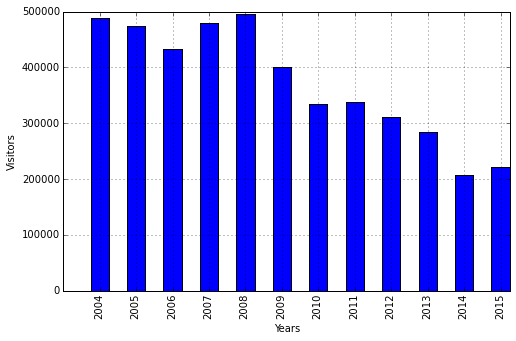

In [105]:
print "CeBIT visitors by year:"
vis=data_df.toPandas()
ax = vis.plot(kind='bar', figsize=(8,5), x='YEAR', y='VISITORS1')
ax.set_ylabel("Visitors")
ax.set_xlabel("Years");

Basic weather data for past CeBIT days


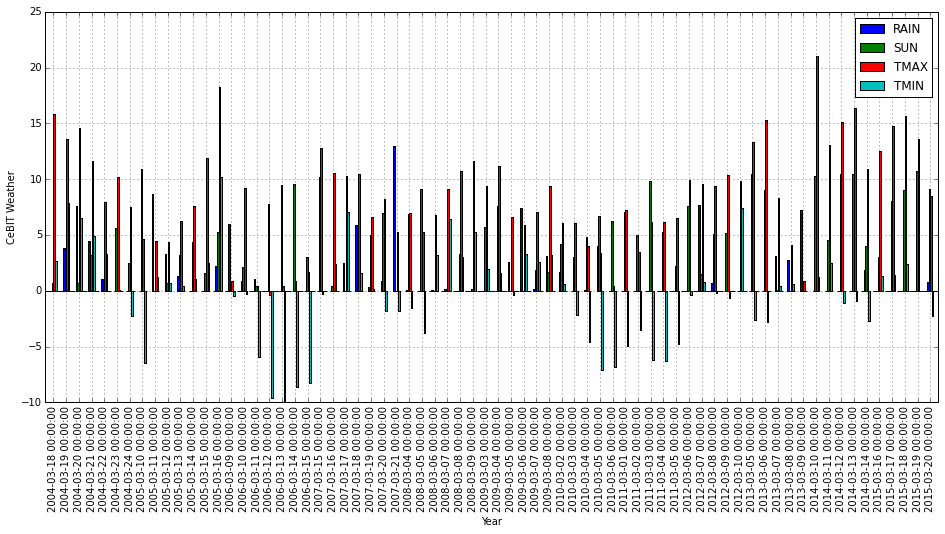

In [106]:
print "Basic weather data for past CeBIT days"
wdf1=wdf.select(wdf['MDATE'],wdf['RAIN'],wdf['SUN'],wdf['TMAX'],wdf['TMIN'])
vis2=wdf1.toPandas()
ax2 = vis2.plot(kind='bar', figsize=(16,7), x='MDATE' )
ax2.set_ylabel("CeBIT Weather")
ax2.set_xlabel("Year")

Our final plot shows the visitor and weather data in context - any relationship?


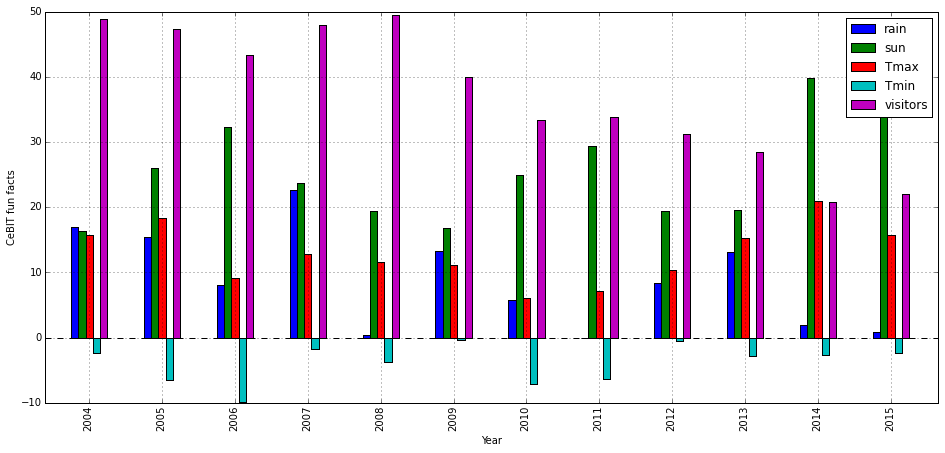

In [107]:
print "Our final plot shows the visitor and weather data in context - any relationship?"
df1=data_df.select(data_df['YEAR'],data_df['RAIN'],data_df['SUN'],data_df['TMAX'],data_df['TMIN'],data_df['VISITORS1']*.0001)
vis1=df1.toPandas()
ax = vis1.plot(kind='bar', figsize=(16,7), x='YEAR', legend=False )
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, ['rain','sun','Tmax','Tmin','visitors'], loc='best')
ax.set_ylabel("CeBIT fun facts")
ax.set_xlabel("Year")